# Семинар 3. Обучение и иже с ним 📕 📗 📘 📙

In [1]:
from typing import Tuple
from random import randrange

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
class FullyConnectedNetwork(nn.Module):  # https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    def __init__(
        self, 
        img_size: Tuple[int, int] = (1, 28, 28),  # (кол-во каналов, высота px, ширина px)
        num_classes: int = 10,
        hidden_size: int = 128,
        n_layers: int = 1,
        activation = nn.ReLU,
        use_bn: bool = False,
    ):
        super().__init__()
        input_features = img_size[0] * img_size[1] * img_size[2]
        
        modules_list = [nn.Linear(input_features, hidden_size), activation()]
        for _ in range(n_layers):
            modules_list += [
                nn.Linear(hidden_size, hidden_size), 
                nn.BatchNorm1d(hidden_size) if use_bn else nn.Identity(), 
                activation(),
            ]
        modules_list.append(nn.Linear(hidden_size, num_classes))
        self.model = nn.Sequential(*modules_list)
        
    def forward(self, x: torch.Tensor):
        return self.model(x)

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.5],
        std=[0.5],
    ),
])

# Загружает и обрабатывает данные.
train_dataset = torchvision.datasets.MNIST(  # MNIST - база изображений рукописных цифр.
    root='datasets',
    download=True,
    train=True,
    transform=transform,
)

# Производит пакетный (batch) поток данных.
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4,
)

In [4]:
valid_dataset = torchvision.datasets.MNIST(
    root='datasets',
    download=True,
    train=False,
    transform=transform,
)

valid_dataloader = torch.utils.data.DataLoader(
    dataset=valid_dataset,
    batch_size=256,
    shuffle=True,
    num_workers=4,
)

In [5]:
criterion = nn.CrossEntropyLoss()  # https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html

def train_step(model, optimizer) -> float:
    model.train()
    
    running_loss = 0.
    for images, labels in train_dataloader:
        images = images.view(images.shape[0], -1).cuda()  # [256, 1, 28, 28] -> [256, 1 * 28 * 28]
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels.cuda())
        loss.backward()
        optimizer.step()
        
        running_loss += loss
    
    with torch.no_grad():
        train_loss = running_loss / len(train_dataloader)
    return train_loss.item()

In [6]:
def valid_step(model) -> Tuple[float, float]:
    model.eval()

    correct_total = 0.
    running_loss = 0.
    with torch.no_grad():
        for images, labels in valid_dataloader:
            images = images.view(images.shape[0], -1).cuda()
            labels = labels.cuda()

            output = model(images)
            
            prediction = output.max(  # [bs, num_classes] -> [bs, 1]
                dim=1,
                keepdim=True,
            )[1] # # .argmax(dim=1)
            correct_total += prediction.eq(labels.view_as(prediction)).sum()
            
            loss = criterion(output, labels)
            running_loss += loss
        
    valid_loss = running_loss / len(valid_dataloader)
    accuracy = correct_total / len(valid_dataloader.dataset)
    return valid_loss.item(), accuracy.item()

In [7]:
def train(epochs, model, optimizer):
    train_losses = []
    valid_losses = []
    valid_accs = []
    
    for _ in (pbar := tqdm(range(epochs))):
        train_loss = train_step(model, optimizer)
        valid_loss, valid_acc = valid_step(model)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)

        pbar.set_description(f'Avg. train/valid loss: {train_loss:.4f}/{valid_loss:.4f}')
    return train_losses, valid_losses, valid_accs

# Backprop

$$ f(x)=g_m(g_{m−1}(…(g_1(x))…)), то \ ∂f/∂x=∂g_m/∂g_{m−1} * ∂g_{m−1}/∂g_{m−2} * … * ∂g_2/∂g_1 * ∂g_1/∂x $$

$$ f′(w_0)=g'_m(g_{m−1}(…g_1(w_0)…))⋅g′_{m−1}(g_{m−2}(…g_1(w_0)…))⋅…⋅g′_1(w_0) $$

Chain rule:
    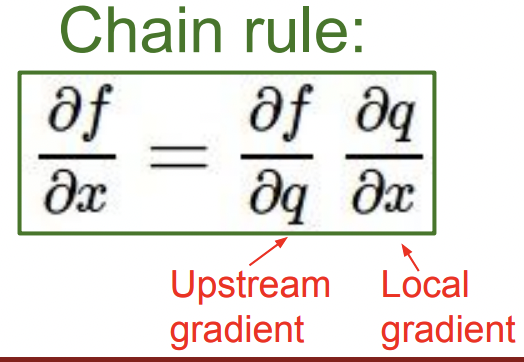

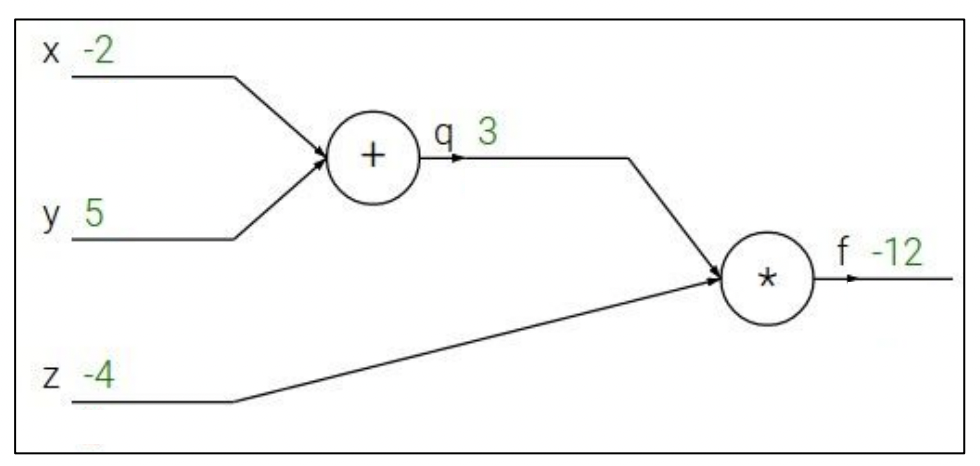

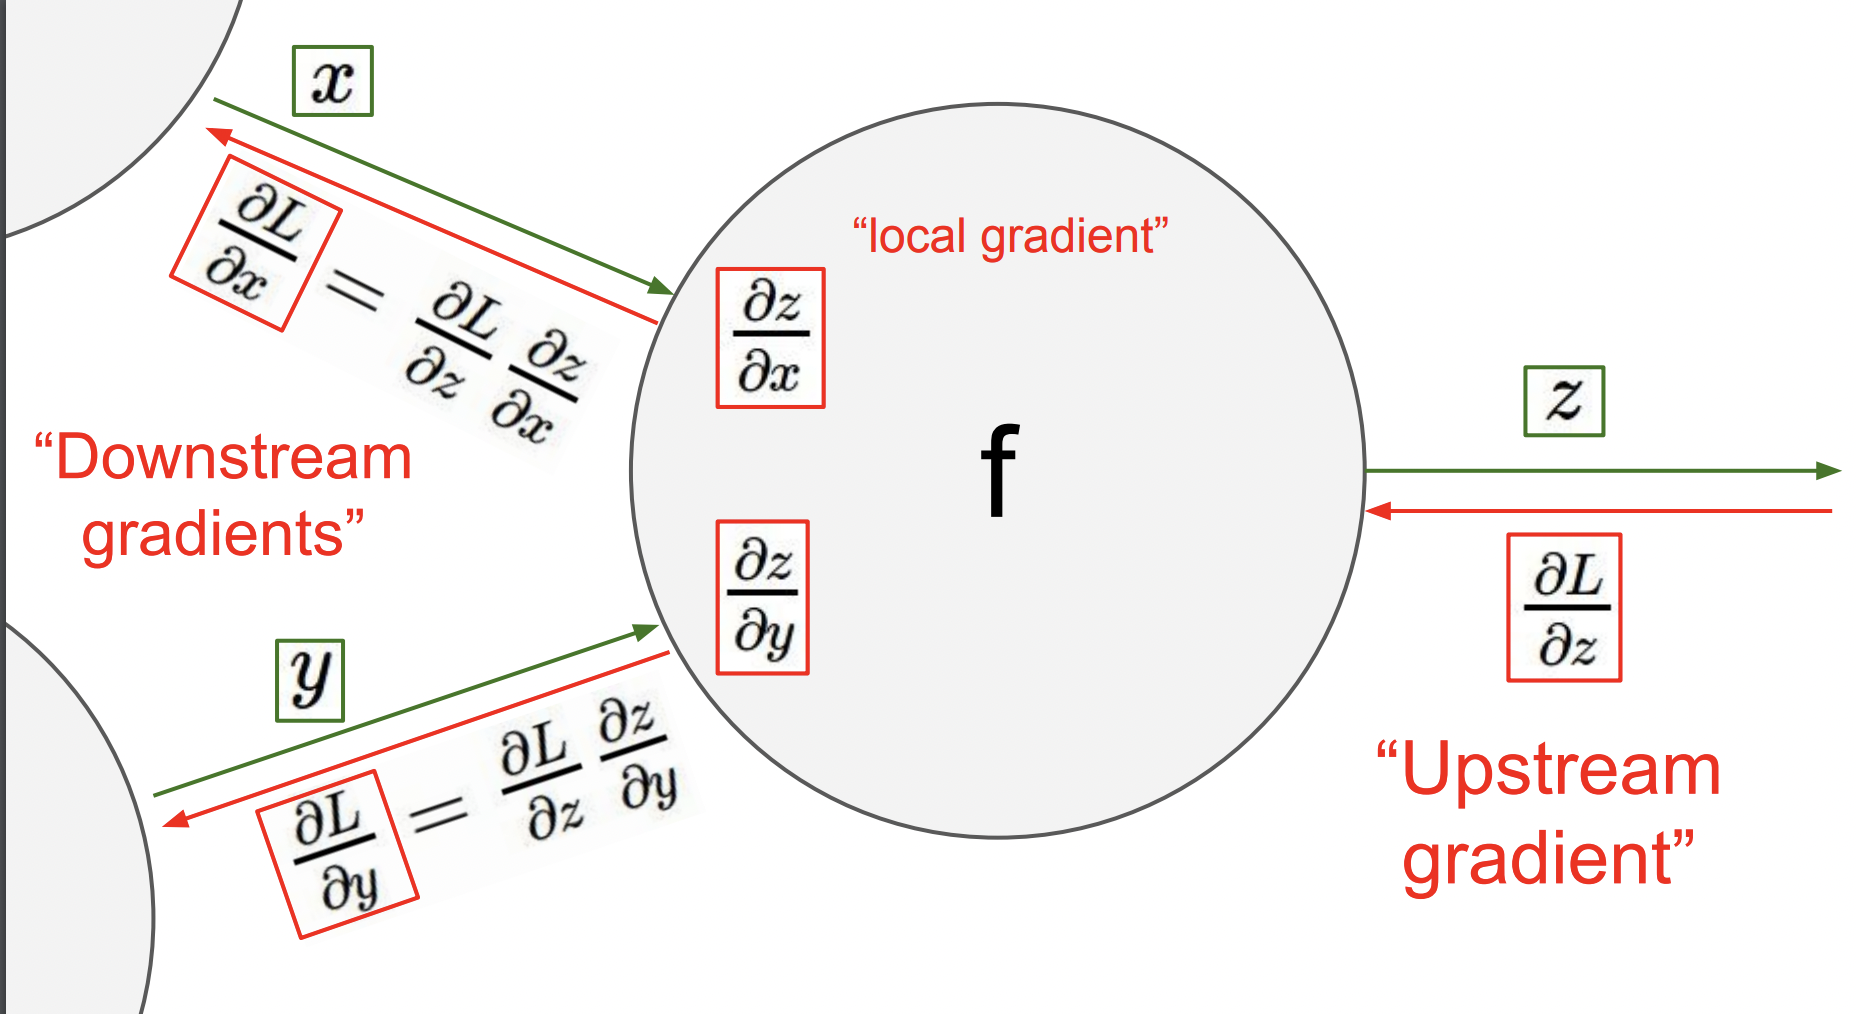

# Weights initialization

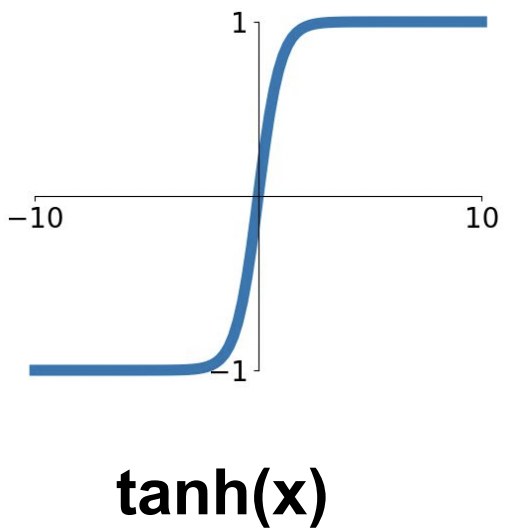

### Gaussian with zero mean and 1e-2 standard deviation and tanh activation

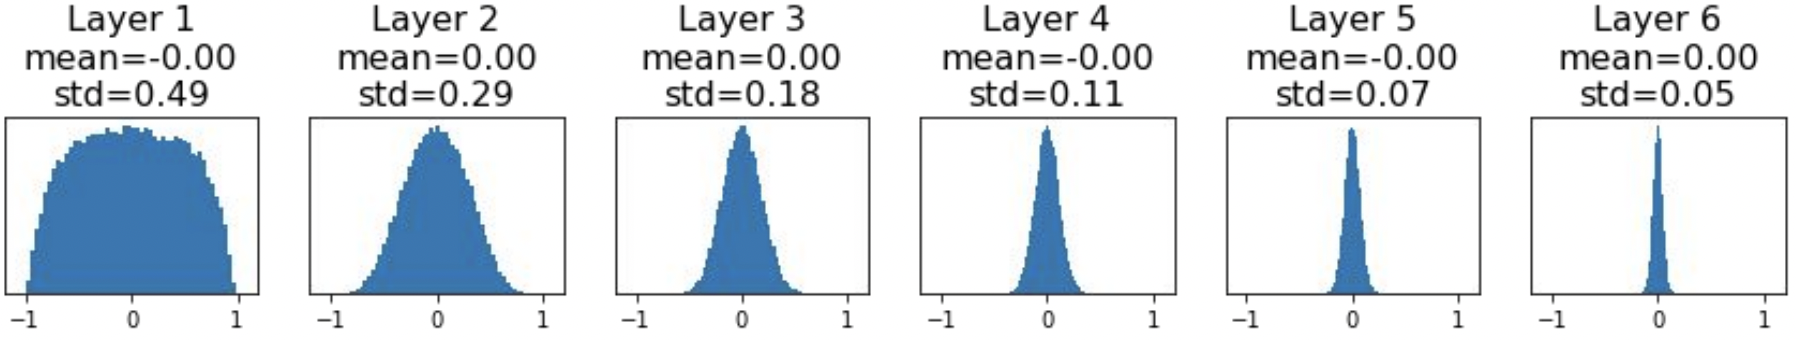

Если веса инициализировать маленькими значениями, то при увеличении глубины выходы слоев будут уменьшаться и в итоге будут почти 0 -> градиенты почти 0 -> не обучается

### Gaussian with zero mean and 5e-2 standard deviation and tanh activation

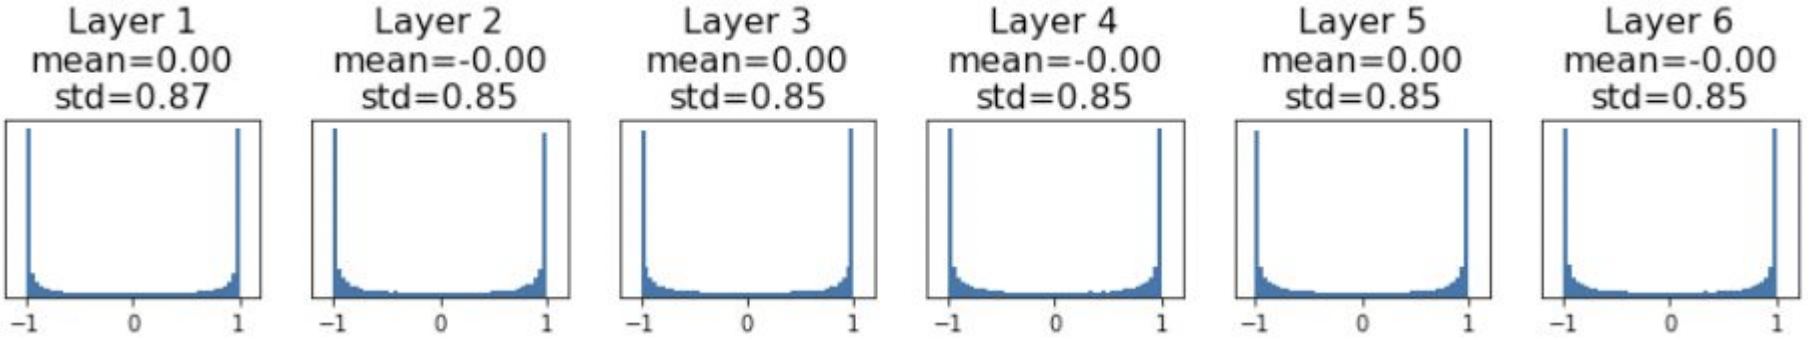

Если веса инициализировать большими значениями, то выходы слоев будут в области насыщении -> градиенты почти 0 -> не обучается

Маленькие и большие значения не годятся, хотелось бы сохранить распределение или хотя бы дисперсию выходов:
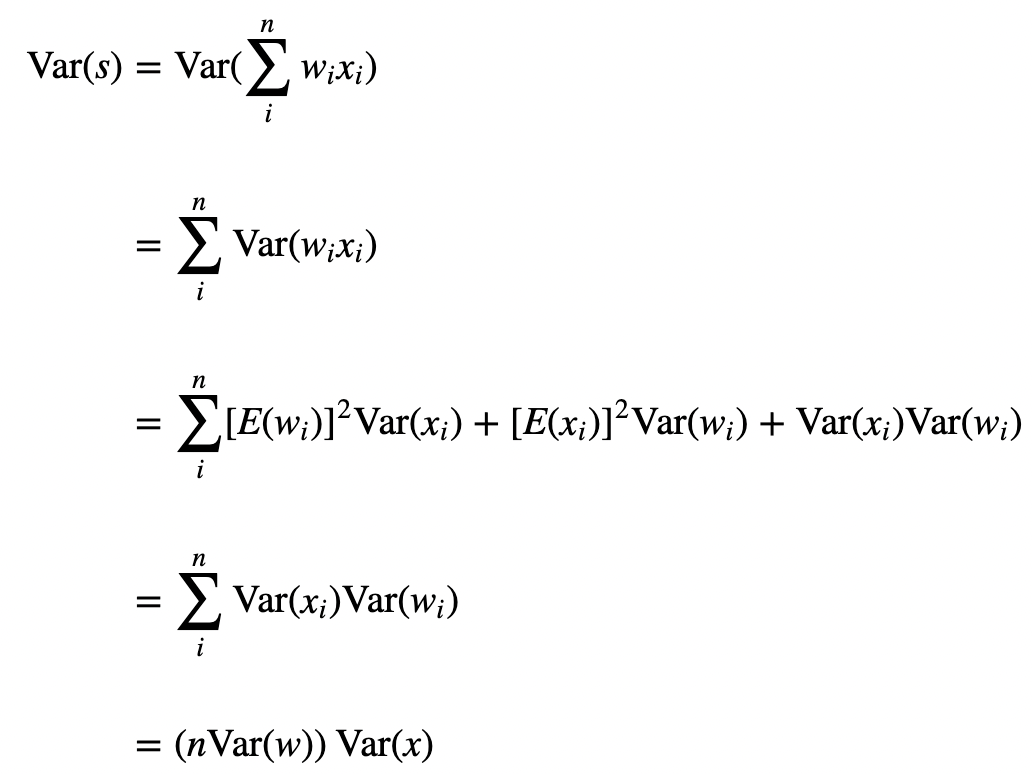

Xavier:  
$$ 1 / sqrt(Din), \ for \ conv \ Din = filter-size^2 + in-filters $$  

Glorot:  
$$ 2 / sqrt(Din + Dout) $$

# ReLU vs Sigmoid

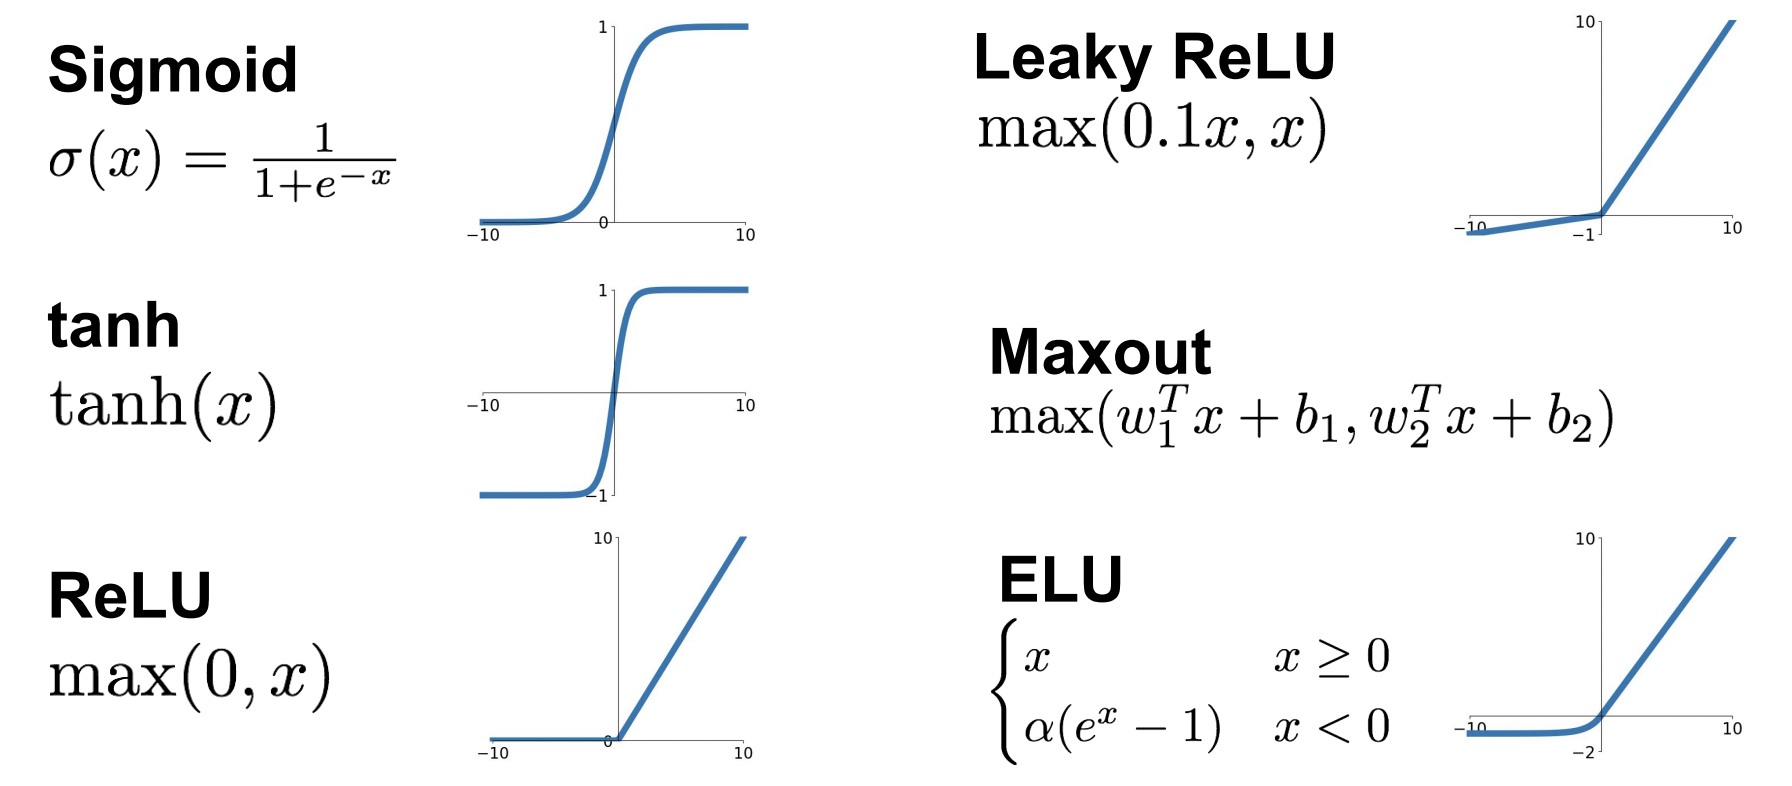

## ReLU

In [14]:
# Going deeper
model = FullyConnectedNetwork(n_layers=7, activation=nn.ReLU, hidden_size=16).cuda()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
stats2 = train(epochs=50, model=model, optimizer=optimizer)

Avg. train/valid loss: 0.1310/0.1939: 100%|█████████████████████████████████████████████████████████████████| 50/50 [02:23<00:00,  2.88s/it]


Text(0, 0.5, 'Loss')

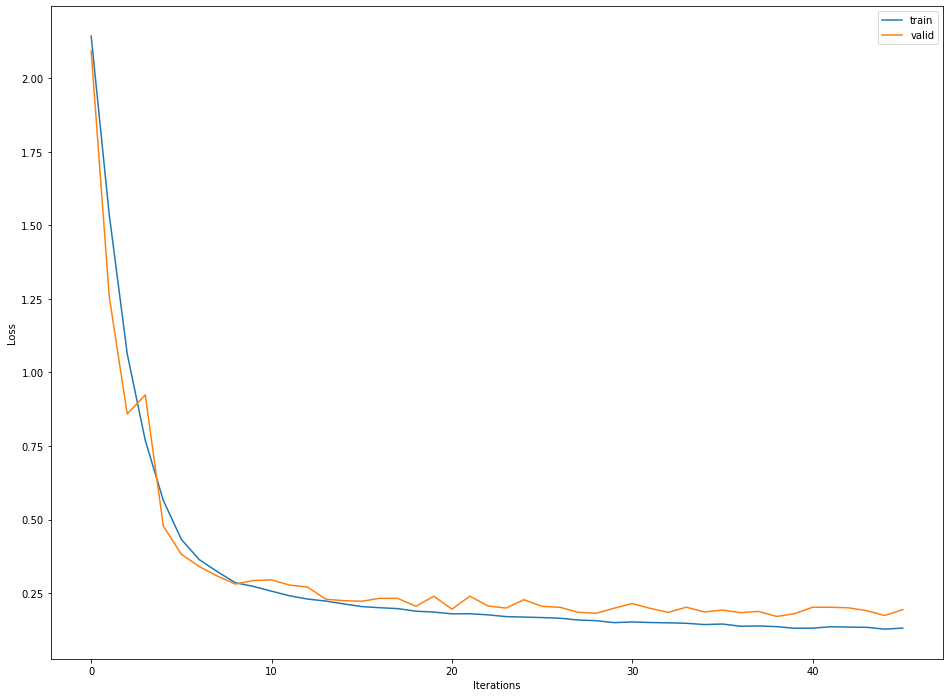

In [15]:
fig = plt.figure(figsize=(16, 12))

plt.plot(stats2[0][4:], label='train')
plt.plot(stats2[1][4:], label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')


## Sigmoid

In [9]:
model = FullyConnectedNetwork(n_layers=7, activation=nn.Sigmoid, hidden_size=16).cuda()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
stats2 = train(epochs=50, model=model, optimizer=optimizer)

Avg. train/valid loss: 2.3016/2.3009: 100%|█████████████████████████████████████████████████████████████████| 50/50 [02:24<00:00,  2.88s/it]


Text(0, 0.5, 'Loss/Accuracy')

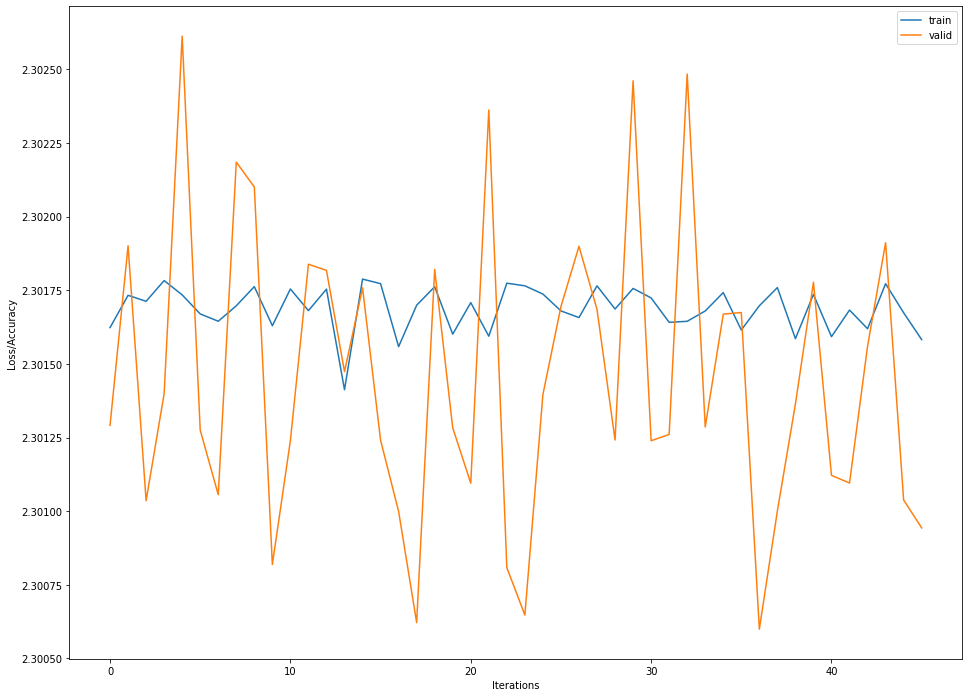

In [13]:
fig = plt.figure(figsize=(16, 12))

plt.plot(stats2[0][4:], label='train')
plt.plot(stats2[1][4:], label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [16]:
model = FullyConnectedNetwork(
    n_layers=7, 
    activation=nn.Sigmoid, 
    hidden_size=16, 
    use_bn=True,
).cuda()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
stats2 = train(epochs=50, model=model, optimizer=optimizer)

Avg. train/valid loss: 0.0917/0.1804: 100%|█████████████████████████████████████████████████████████████████| 50/50 [02:24<00:00,  2.89s/it]


Text(0, 0.5, 'Loss')

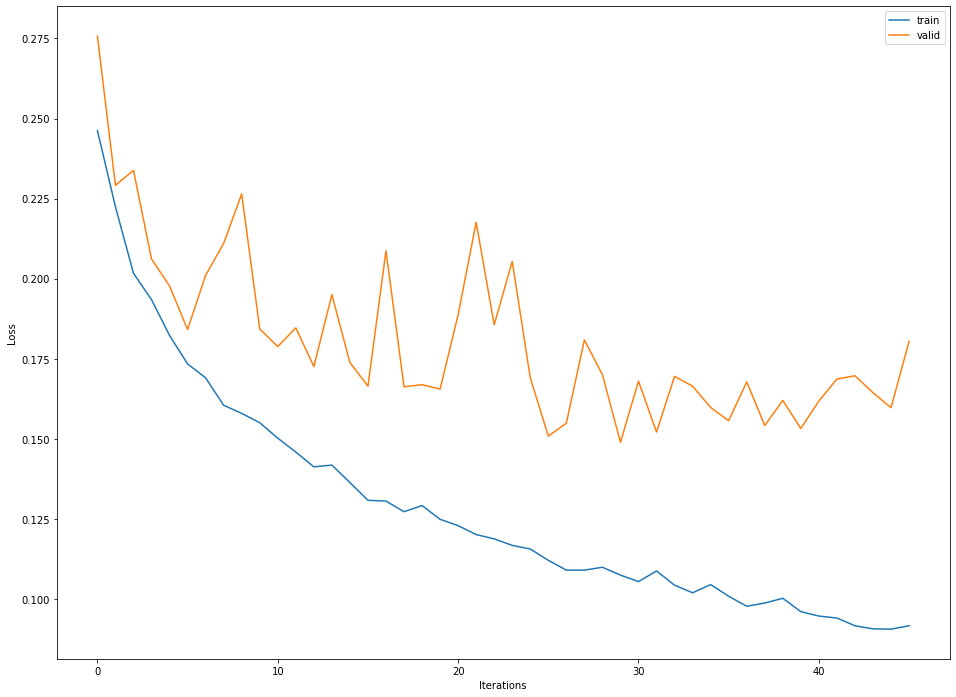

In [17]:
fig = plt.figure(figsize=(16, 12))

plt.plot(stats2[0][4:], label='train')
plt.plot(stats2[1][4:], label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

Sigmoid:
* Насыщенные нейроны убивают градиенты
* exp() вычислительно затратно

# Batch normalization

Проблемы:
* Маленький LR
* Сильная зависимость от начальных весов

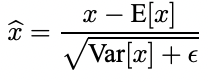

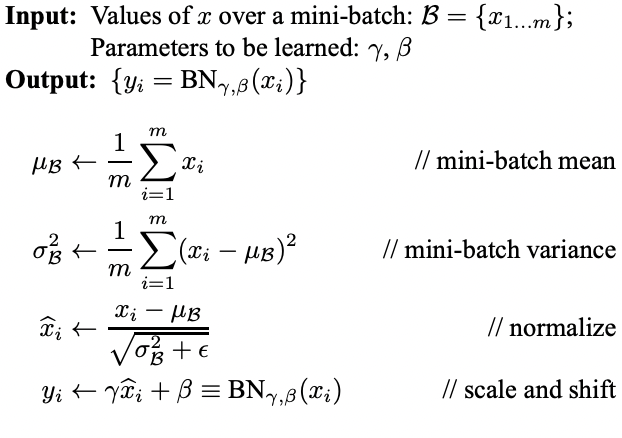

In [25]:
model = FullyConnectedNetwork(
    n_layers=3, 
    activation=nn.ReLU, 
    hidden_size=16, 
    use_bn=False,
).cuda()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
stats2 = train(epochs=50, model=model, optimizer=optimizer)

Avg. train/valid loss: 0.0970/0.1589: 100%|█████████████████████████████████████████████████████████████████| 50/50 [02:23<00:00,  2.87s/it]


Text(0, 0.5, 'Loss')

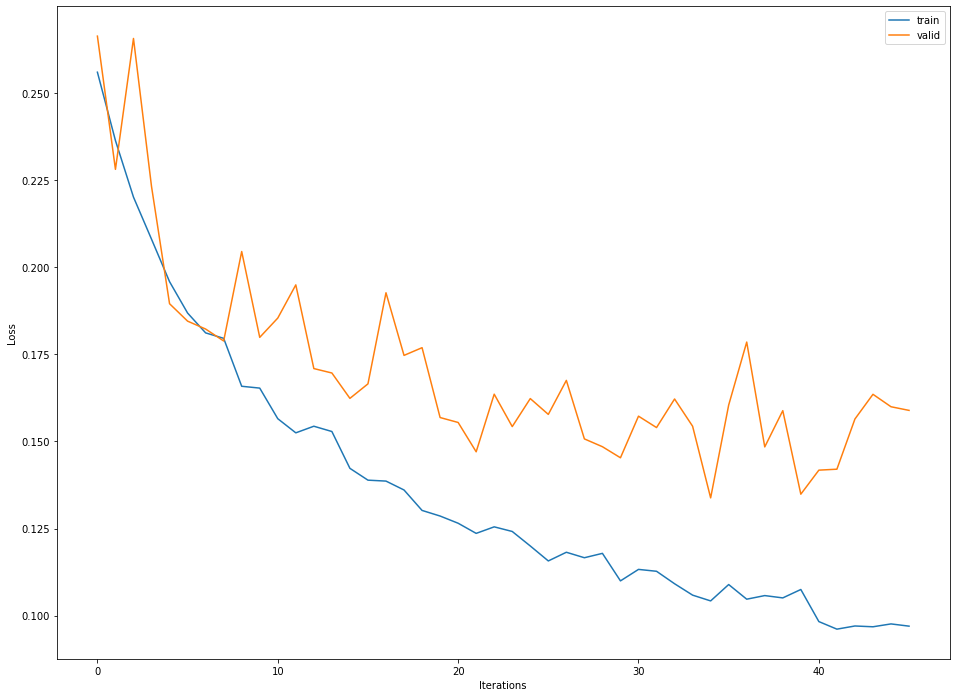

In [26]:
fig = plt.figure(figsize=(16, 12))

plt.plot(stats2[0][4:], label='train')
plt.plot(stats2[1][4:], label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [32]:
model = FullyConnectedNetwork(
    n_layers=3, 
    activation=nn.ReLU, 
    hidden_size=16, 
    use_bn=False,
).cuda()

state_dict = model.state_dict()
for name in state_dict:
    state_dict[name] *= 100
model.load_state_dict(state_dict)

<All keys matched successfully>

In [33]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
stats2 = train(epochs=50, model=model, optimizer=optimizer)

Avg. train/valid loss: 2.3013/2.3008: 100%|█████████████████████████████████████████████████████████████████| 50/50 [02:23<00:00,  2.87s/it]


Text(0, 0.5, 'Loss')

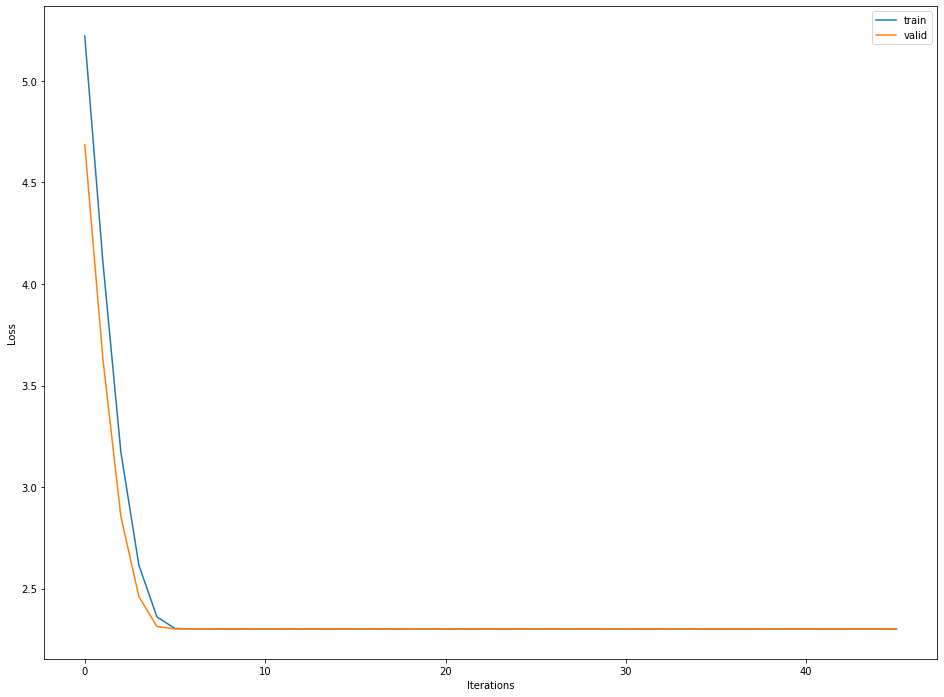

In [34]:
fig = plt.figure(figsize=(16, 12))

plt.plot(stats2[0][4:], label='train')
plt.plot(stats2[1][4:], label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

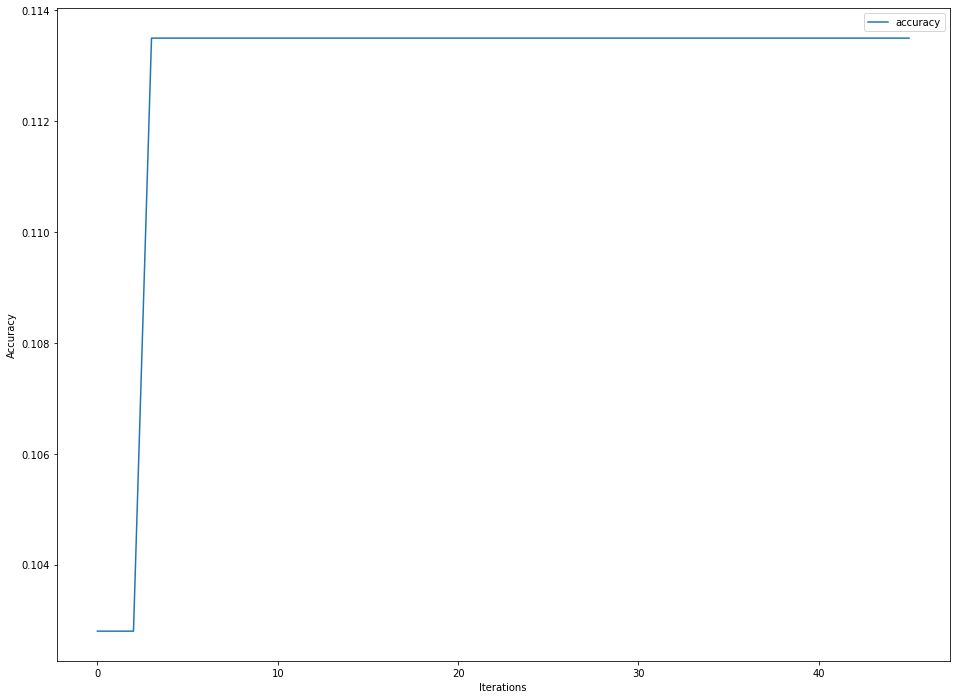

In [35]:
fig = plt.figure(figsize=(16, 12))

plt.plot(stats2[-1][4:], label='accuracy')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Accuracy')

In [8]:
model = FullyConnectedNetwork(
    n_layers=3, 
    activation=nn.ReLU, 
    hidden_size=16, 
    use_bn=False,
).cuda()

state_dict = model.state_dict()
for name in state_dict:
    state_dict[name] *= 0.001
model.load_state_dict(state_dict)

<All keys matched successfully>

In [9]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
stats2 = train(epochs=50, model=model, optimizer=optimizer)

Avg. train/valid loss: 2.3013/2.3008: 100%|█████████████████████████████████████████████████████████████████| 50/50 [02:24<00:00,  2.89s/it]


Text(0, 0.5, 'Loss')

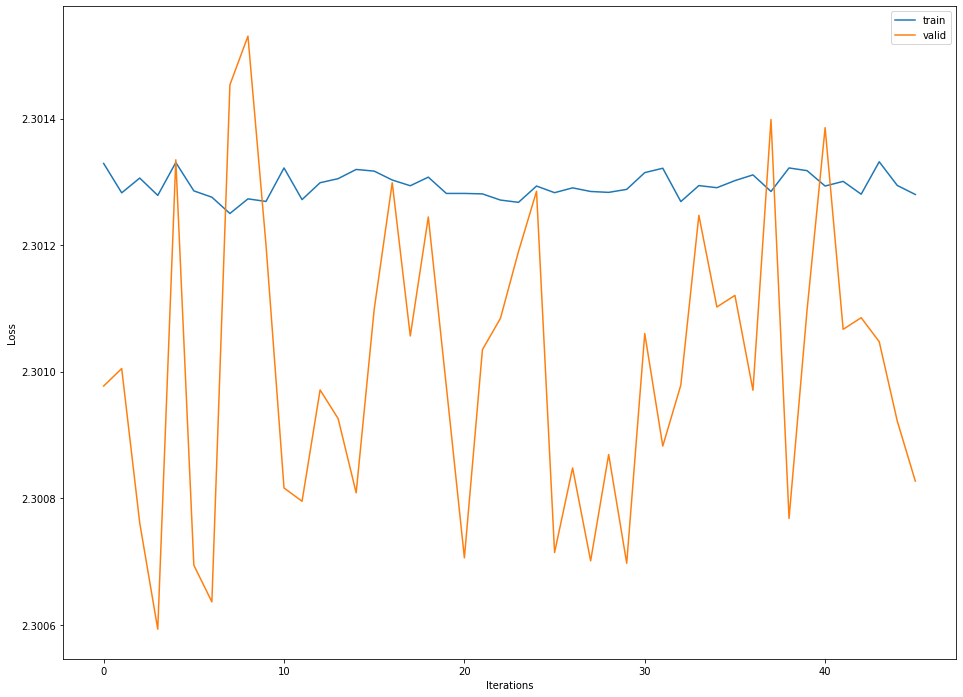

In [10]:
fig = plt.figure(figsize=(16, 12))

plt.plot(stats2[0][4:], label='train')
plt.plot(stats2[1][4:], label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

In [17]:
model = FullyConnectedNetwork(
    n_layers=3, 
    activation=nn.ReLU, 
    hidden_size=16, 
    use_bn=True,
).cuda()

state_dict = model.state_dict()
for name in state_dict:
    if state_dict[name].numel() == 16 or state_dict[name].numel() == 1:
        continue
    state_dict[name] *= 0.001
model.load_state_dict(state_dict)

<All keys matched successfully>

In [18]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01, momentum=0.9)
stats2 = train(epochs=50, model=model, optimizer=optimizer)

Avg. train/valid loss: 0.1977/0.2282: 100%|█████████████████████████████████████████████████████████████████| 50/50 [02:25<00:00,  2.91s/it]


Text(0, 0.5, 'Loss')

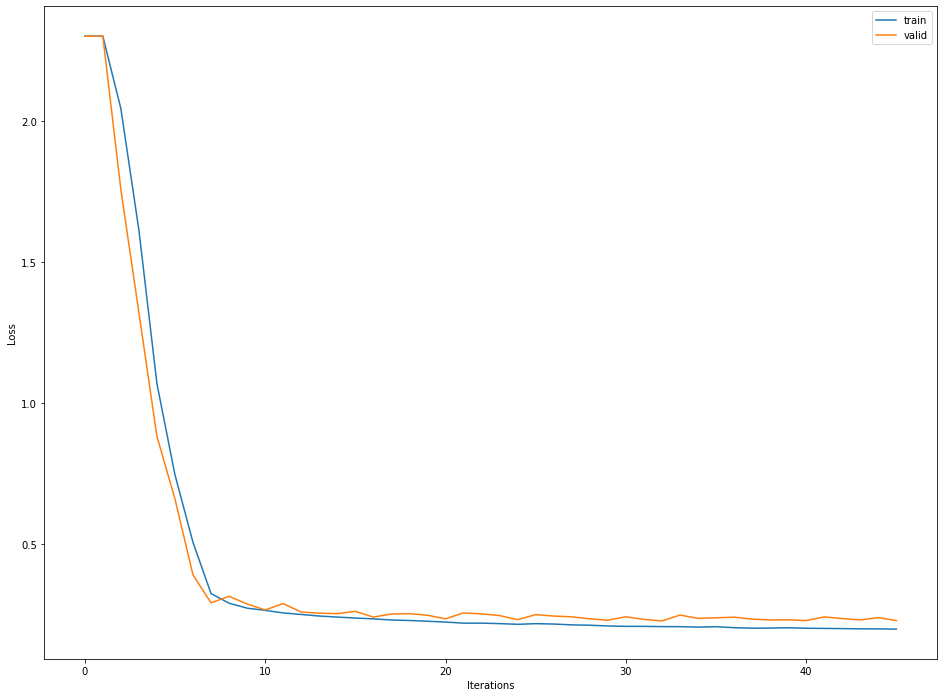

In [19]:
fig = plt.figure(figsize=(16, 12))

plt.plot(stats2[0][4:], label='train')
plt.plot(stats2[1][4:], label='valid')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Loss')

Итого:
* Помогает от насыщений
* Меньше зависимости от начальных весов
* Можно использовать бОльший LR
* Регуляризация, более быстрая сходимость

Почему это работает?
* Внуренний ковариационный сдвиг
* Репараметризация задачи оптимизации и более гладкая функция потерь  
Никто пока не знает...

# Learning rates

Сильно большой LR - можно не сойтись  
Сильно маленький LR - слишком долго и можно застрять   

In [23]:
from functools import partial
optimizers = {
    'SGD lr=1.0': partial(torch.optim.SGD, lr=0.8, momentum=0.9),
    'SGD lr=0.1': partial(torch.optim.SGD, lr=0.1, momentum=0.9),
    'SGD lr=0.01': partial(torch.optim.SGD, lr=0.01, momentum=0.9),
    'SGD lr=0.001': partial(torch.optim.SGD, lr=0.001, momentum=0.9),
    'SGD lr=0.0001': partial(torch.optim.SGD, lr=0.0001, momentum=0.9),
}

stats: set = {}

for opt_name, opt in optimizers.items():
    model = FullyConnectedNetwork(n_layers=2, activation=nn.ReLU, hidden_size=128).cuda()
    stats[opt_name] = train(epochs=50, model=model, optimizer=opt(params=model.parameters()))

Avg. train/valid loss: 0.4626/0.4448: 100%|█████████████████████████████████████████████████████████████████| 50/50 [02:25<00:00,  2.90s/it]


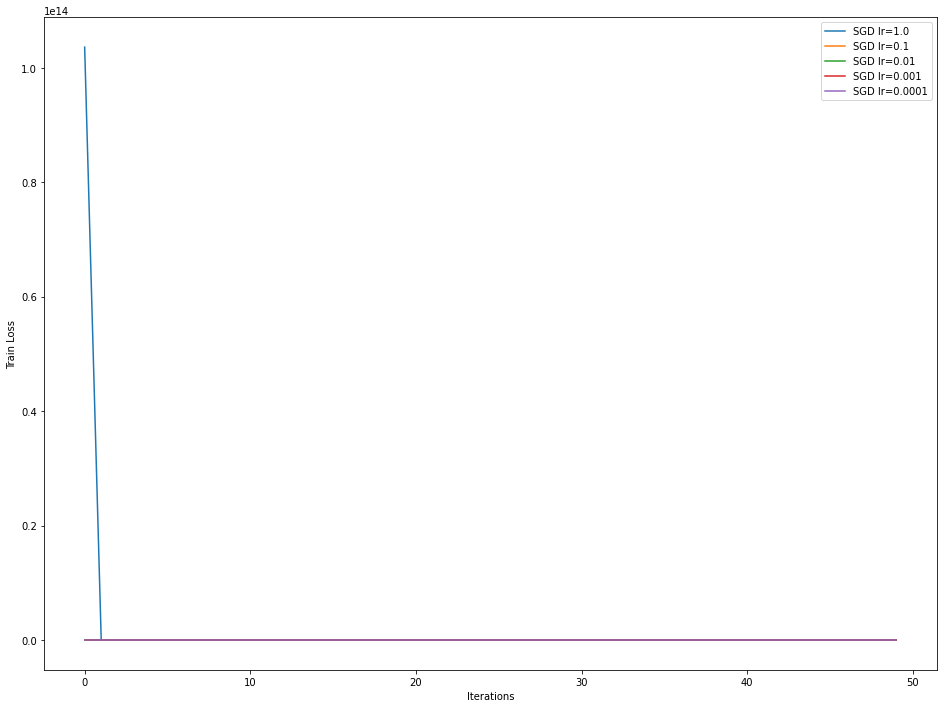

In [24]:
fig = plt.figure(figsize=(16, 12))

for opt_name, statistics in stats.items():
    plt.plot(statistics[-3], label=opt_name)
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Train Loss')

In [20]:
from functools import partial
optimizers = {
    'SGD lr=0.1': partial(torch.optim.SGD, lr=0.1, momentum=0.9),
    'SGD lr=0.01': partial(torch.optim.SGD, lr=0.01, momentum=0.9),
    'SGD lr=0.001': partial(torch.optim.SGD, lr=0.001, momentum=0.9),
    'SGD lr=0.0001': partial(torch.optim.SGD, lr=0.0001, momentum=0.9),
}

stats: set = {}

for opt_name, opt in optimizers.items():
    model = FullyConnectedNetwork(n_layers=2, activation=nn.ReLU, hidden_size=128, use_bn=True).cuda()
    stats[opt_name] = train(epochs=50, model=model, optimizer=opt(params=model.parameters()))

Avg. train/valid loss: 0.1459/0.1538: 100%|█████████████████████████████████████████████████████████████████| 50/50 [02:25<00:00,  2.91s/it]


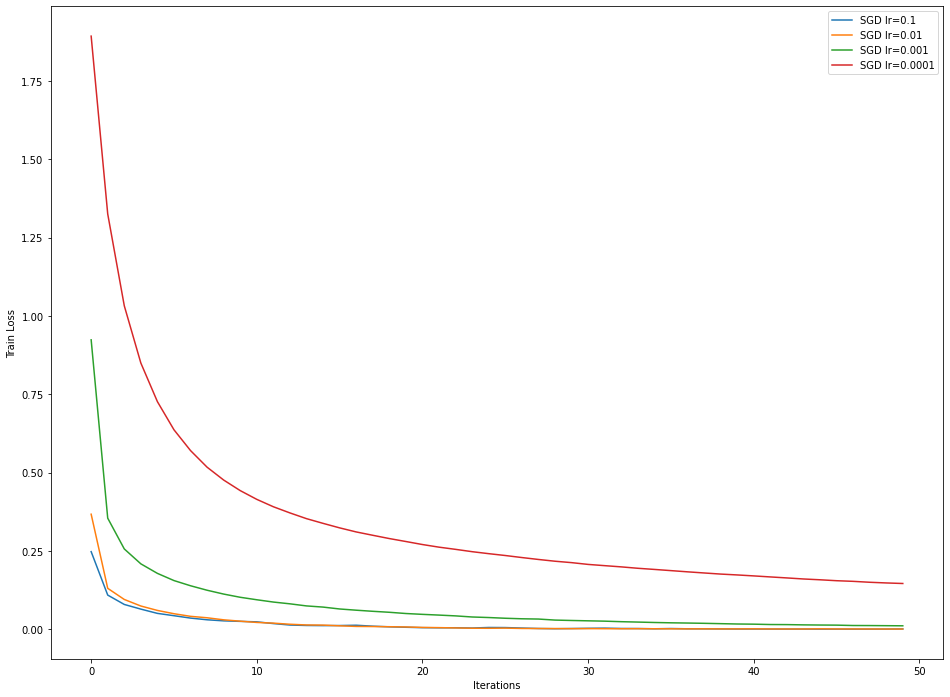

In [21]:
fig = plt.figure(figsize=(16, 12))

for opt_name, statistics in stats.items():
    plt.plot(statistics[-3], label=opt_name)
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Train Loss')

# Compare different optimizers

SGD: 
    x += - learning_rate * dx
    
SGD with momentum - принимаем во внимание прошлые градиенты:  
    v = mu * v - learning_rate * dx # integrate velocity  
    x += v # integrate position  
    
Adam:  
    m = beta1 * m + (1-beta1) * dx  
    v = beta2 * v + (1-beta2) * (dx**2)  
    x += - learning_rate * m / (np.sqrt(v) + eps)  

In [14]:
from functools import partial
optimizers = {
    'SGD': partial(torch.optim.SGD, lr=0.01),
    'SGD_with_momentum': partial(torch.optim.SGD, lr=0.01, momentum=0.9),
    'Adam': partial(torch.optim.Adam, lr=0.01),
}

stats: set = {}

for opt_name, opt in optimizers.items():
    model = FullyConnectedNetwork(n_layers=2, activation=nn.ReLU, hidden_size=128).cuda()
    stats[opt_name] = train(epochs=50, model=model, optimizer=opt(params=model.parameters()))

Avg. train/valid loss: 0.0985/0.2041: 100%|█████████████████████████████████████████████████████████████████| 50/50 [02:25<00:00,  2.92s/it]


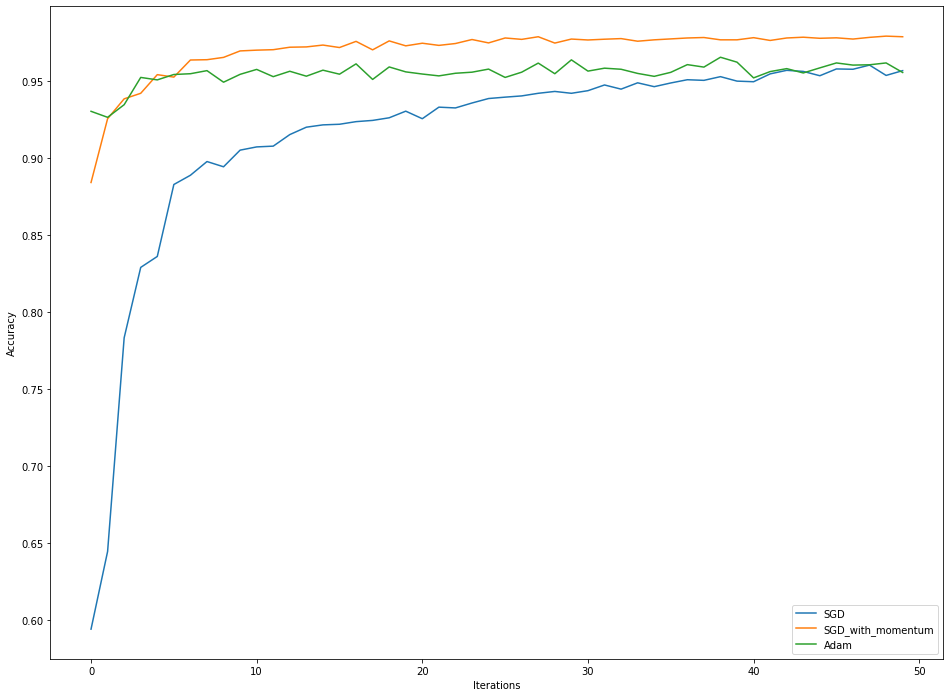

In [15]:
fig = plt.figure(figsize=(16, 12))

for opt_name, statistics in stats.items():
    plt.plot(statistics[-1], label=opt_name)
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')

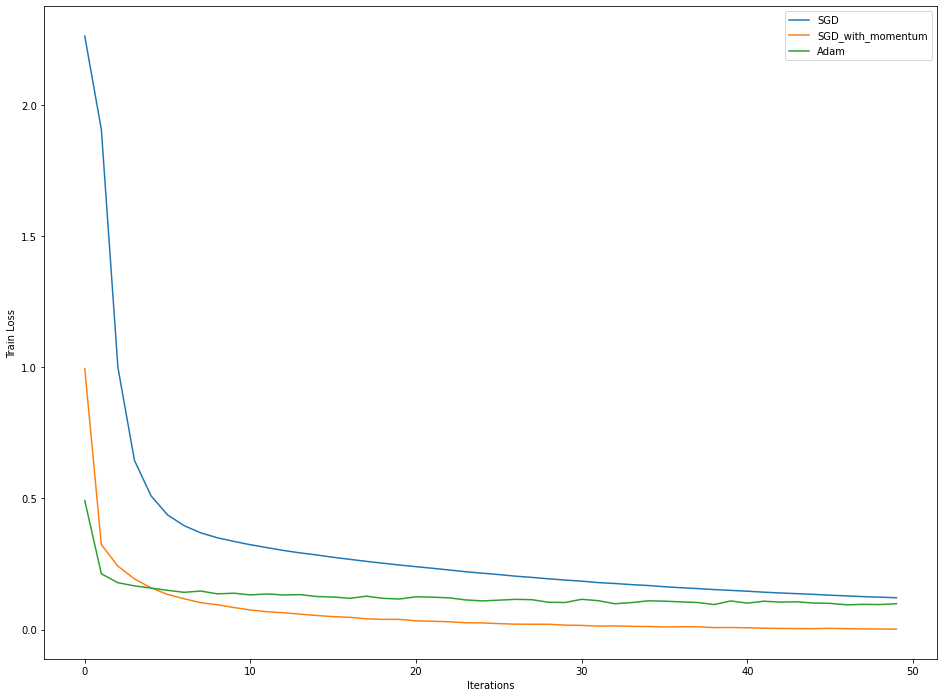

In [18]:
fig = plt.figure(figsize=(16, 12))

for opt_name, statistics in stats.items():
    plt.plot(statistics[-3], label=opt_name)
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Train Loss')

SGD:  
    Лучше обобщающая способность  
    
Adam:  
    Быстрее сходится  